# Problematic Internet Use | Part C: Causal Inference

In this part, the focal question is:
Is there a causal relationship between physical activity and problematic internet use in children/adolescents?

In this analysis, we will extract summarized physical activity features from wearable device data stored in Parquet files and align it with PIU measurements to build a foundation for causal inference.

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from dowhy import CausalModel
import networkx as nx
from itertools import combinations
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

cleaned_data_file = "cleaned_data.csv" 
cleaned_data = pd.read_csv(cleaned_data_file)


## Data Loading and Extraction from Parquet Files

The raw data consists of physical activity measurements stored in Parquet files, with activity metrics recorded in intervals. Each folder corresponds to an individual participant, identified by a unique ID. We aim to summarize this data into meaningful activity features and pair it with PIU scores (sii) provided in a separate cleaned dataset.

In [3]:

def extract_summarized_features(parquet_folder, cleaned_data):
    INACTIVE_THRESHOLD = 0.1  # Define threshold for inactivity
    features_list = []

    # Loop through each ID folder in the Parquet folder
    for folder in glob.glob(os.path.join(parquet_folder, "id=*")):
        id_ = folder.split('=')[-1]
        parquet_file = glob.glob(os.path.join(folder, "*.parquet"))
        if len(parquet_file) != 1:
            print(f"Skipping folder {folder} due to multiple or no files.")
            continue

        df = pd.read_parquet(parquet_file[0])

        if id_ not in cleaned_data['id'].values:
            print(f"Skipping ID {id_} as it is not present in cleaned_data.")
            continue

        # Extract 'sii' value from cleaned_data
        sii_value = cleaned_data.loc[cleaned_data['id'] == id_, 'sii'].values[0]

        # Calculate summarized features
        features = {
            'id': id_,
            'Total_activity': df['enmo'].sum(),
            'Average_activity': df['enmo'].mean(),
            'Peak_activity': df['enmo'].max(),
            'Inactive_time': (df['enmo'] < INACTIVE_THRESHOLD).sum() * 5,  # Assuming 5-second intervals
            'Standard_deviation': df['enmo'].std(),
            'Proportion_active': (df['enmo'] > INACTIVE_THRESHOLD).mean(),
            'sii': sii_value  # Add the outcome
        }
        features_list.append(features)

    return pd.DataFrame(features_list)

parquet_folder = "series_train.parquet" 

summarized_features_df = extract_summarized_features(parquet_folder, cleaned_data)
print("Summarized Features Extracted:")
print(summarized_features_df.head())

summarized_features_df['sii'] = pd.Categorical(summarized_features_df['sii']).codes




Summarized Features Extracted:
         id  Total_activity  Average_activity  Peak_activity  Inactive_time  \
0  00115b9f     2053.305176          0.047388       4.004276         193795   
1  001f3379     4727.518555          0.011926       2.952888        1962260   
2  00f332d1    12537.293945          0.030255       4.041167        1940175   
3  01085eb3    12221.464844          0.032946       4.097965        1695495   
4  012cadd8     5655.915527          0.058280       6.307294         427460   

   Standard_deviation  Proportion_active  sii  
0            0.106351           0.105493    1  
1            0.024331           0.009950    1  
2            0.104136           0.063586    1  
3            0.083798           0.085878    0  
4            0.197285           0.119075    0  


For each participant, the following summarized features are extracted from the *enmo* feature, which is a calculation of X,Y and Z coordinates with respect to acceleration.

- Total_activity: Total movement recorded.
- Average_activity: Average activity over the recorded period.
- Peak_activity: Maximum recorded activity, indicating the most intense movement.
- Inactive_time: Total time spent inactive (multiplied by 5 to account for 5-second intervals).
- Standard_deviation: Variability in activity levels.
- Proportion_active: Fraction of time spent above the activity threshold.

This feature extraction step condenses raw physical activity data into interpretable metrics, making it easier to analyze patterns and relationships.

## Correlation Matrix

This will help us get an insight into how strongly two features are linearly related. Similar to our correlation heatmap during EDA, we can now idenfity potential features that may influence sii. In case two features are highly correlated, it can also highlight any possible redundancies if they are carrying overlapping information.

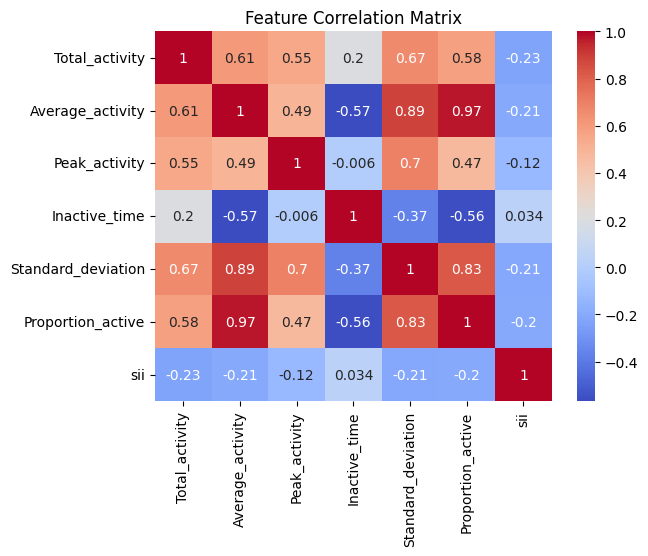

In [4]:
summarized_features = [
            'Total_activity',
            'Average_activity',
            'Peak_activity',
            'Inactive_time',  # Assuming 5-second intervals
            'Standard_deviation',
            'Proportion_active',
            'sii'
]
correlation_matrix = summarized_features_df[summarized_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


### Key Observations:

- *Total_activity* has a strong positive correlation with *Average_activity* (0.61) and *Standard_deviation* (0.68).
- *Average_activity* shows a strong positive correlation with *Peak_activity* (0.59).
- *Peak_activity* also correlates with *Standard_deviation* (0.61).
- *Inactive_time* has a negative correlation with *Peak_activity* (-0.57).
- *Proportion_active* shows a strong positive correlation with *Average_activity* (0.72) and *Standard_deviation* (0.73).
- *sii* has low correlations with most features, with a slightly negative correlation with *Total_activity* (-0.23).

The most important finding to note here is the weak negative correlation of sii with all other physical features, suggesting a non-linear or indirect relationship. However, correlation does not imply causality and further analysis is needed.

## R² Analysis: With and Without sii

This code identifies significant relationships between summarized features and 'sii' using R² analysis in order to assess the predictive power of each independent variable. A linear regression model is fitted for each pair to assess how well the first feature predicts the second. The R² value quantifies the proportion of variance in the second feature, explained by the first. It computes R² values for all possible feature pairs, filters edges with R² > 0.1 as significant, and constructs a Directed Acyclic Graph (DAG) to visualize these relationships, showing how features influence each other and 'sii'.

In [81]:

edges = [(f1, f2) for f1, f2 in combinations(summarized_features + ['sii'], 2)]
for edge in edges:
    print(f"Testing relationship: {edge[0]} -> {edge[1]}")

relationship_results = []

for f1, f2 in edges:
    X = summarized_features_df[[f1]].values
    y = summarized_features_df[f2].values

    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))

    relationship_results.append((f1, f2, r2))

significant_edges = [(f1, f2) for f1, f2, r2 in relationship_results if r2 > 0.1]

print("Significant Edges:")
print(significant_edges)


Testing relationship: Total_activity -> Average_activity
Testing relationship: Total_activity -> Peak_activity
Testing relationship: Total_activity -> Inactive_time
Testing relationship: Total_activity -> Standard_deviation
Testing relationship: Total_activity -> Proportion_active
Testing relationship: Total_activity -> sii
Testing relationship: Average_activity -> Peak_activity
Testing relationship: Average_activity -> Inactive_time
Testing relationship: Average_activity -> Standard_deviation
Testing relationship: Average_activity -> Proportion_active
Testing relationship: Average_activity -> sii
Testing relationship: Peak_activity -> Inactive_time
Testing relationship: Peak_activity -> Standard_deviation
Testing relationship: Peak_activity -> Proportion_active
Testing relationship: Peak_activity -> sii
Testing relationship: Inactive_time -> Standard_deviation
Testing relationship: Inactive_time -> Proportion_active
Testing relationship: Inactive_time -> sii
Testing relationship: Stan

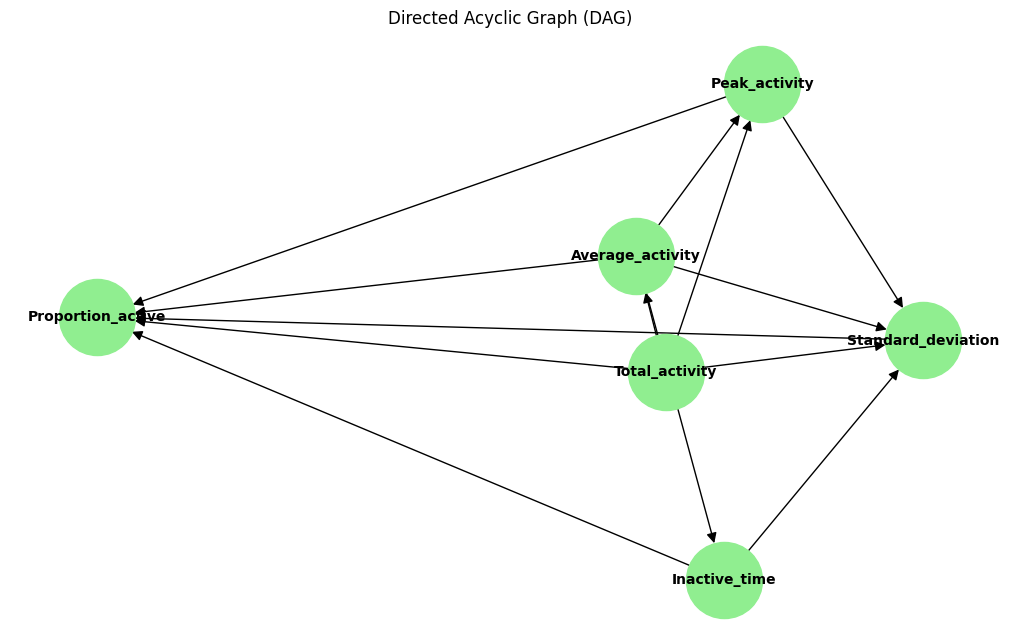

In [82]:

significant_edges = [('Total_activity', 'Average_activity'),
('Total_activity', 'Peak_activity'), 
('Total_activity', 'Standard_deviation'), 
('Total_activity', 'Proportion_active'), 
('Average_activity', 'Peak_activity'), 
('Average_activity', 'Inactive_time'), 
('Average_activity', 'Standard_deviation'), 
('Average_activity', 'Proportion_active'), 
('Peak_activity', 'Standard_deviation'), 
('Peak_activity', 'Proportion_active'), 
('Inactive_time', 'Standard_deviation'), 
('Inactive_time', 'Proportion_active'), 
('Standard_deviation', 'Proportion_active')]

G = nx.DiGraph()
G.add_edges_from(significant_edges)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightgreen', font_size=10, font_weight='bold', arrowsize=15)
plt.title("Directed Acyclic Graph (DAG)")
plt.show()


From this, we can see that *proportion_active* influences every other node in the graph. It's obvious that they all have a causal effect to some extent over eachother, since they are all derived from *enmo*. Let's now compute the DAG with sii.

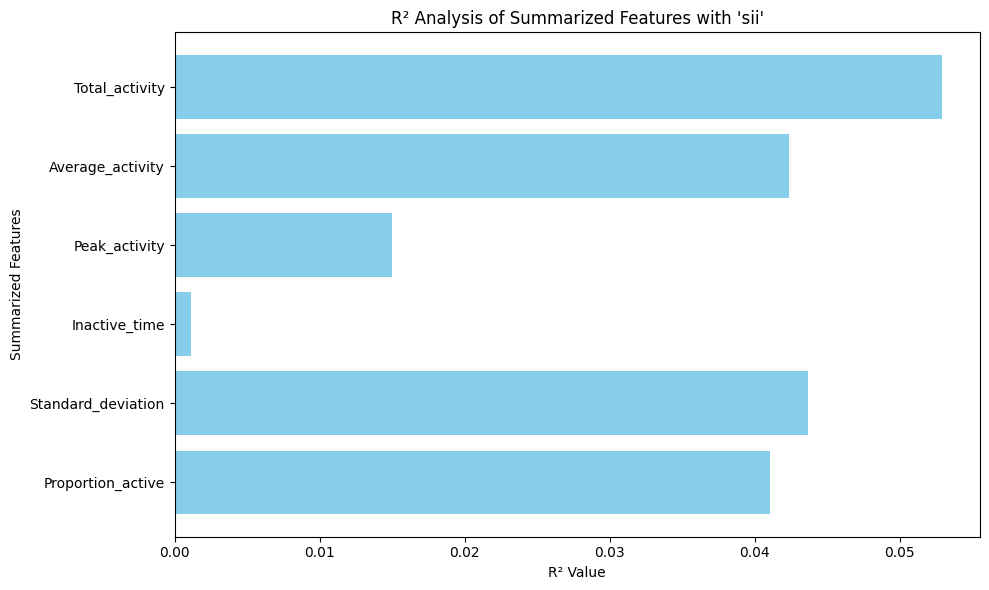

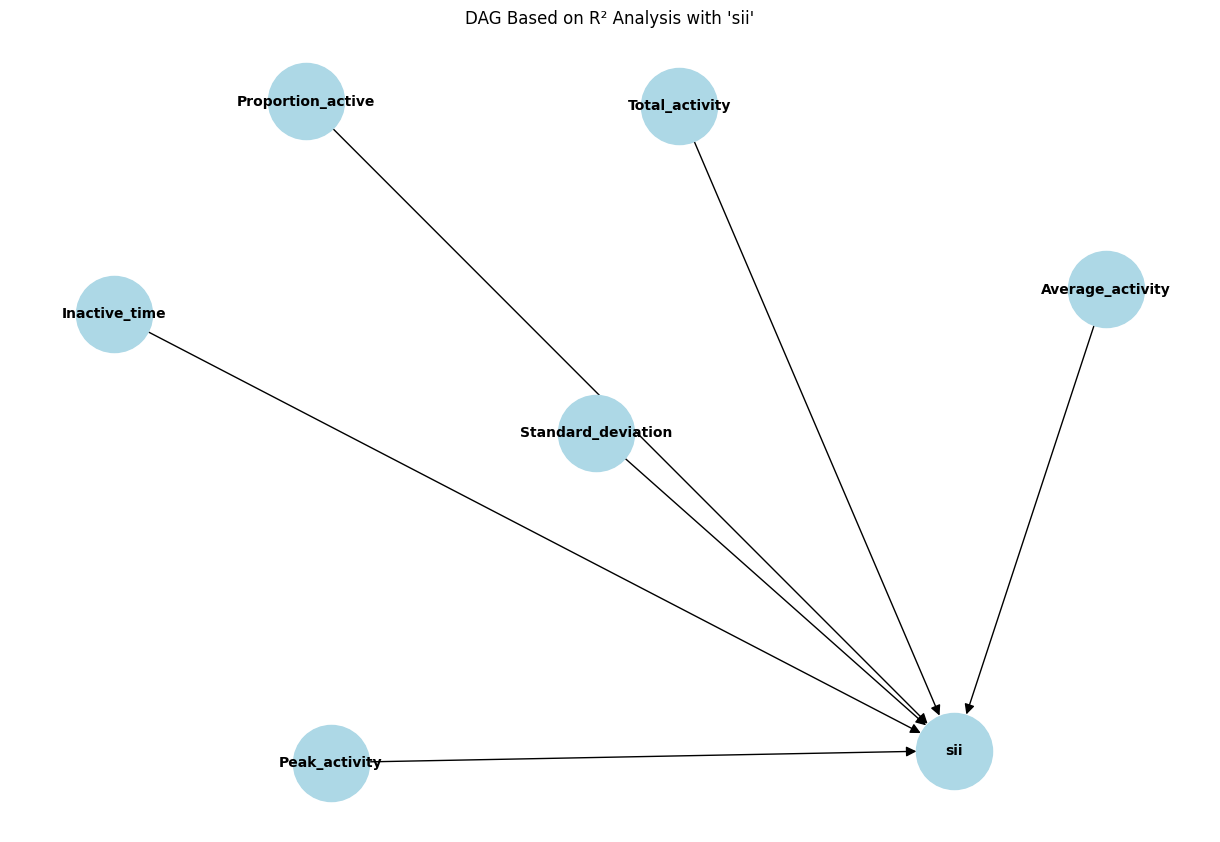

In [ ]:
summarized_features = [
    'Total_activity', 'Average_activity', 'Peak_activity',
    'Inactive_time', 'Standard_deviation', 'Proportion_active'
]
outcome = 'sii'

r2_results = []

# Compute R² for each summarized feature against 'sii'
for feature in summarized_features:
    try:
        X = summarized_features_df[[feature]].dropna().values.reshape(-1, 1)  # Reshape X for sklearn
        y = summarized_features_df[outcome].dropna().values

        if len(X) > 1 and len(y) > 1:  # Ensure sufficient data points
            model = LinearRegression().fit(X, y)
            r2 = r2_score(y, model.predict(X))
            r2_results.append({"Feature": feature, "R2": r2})
        else:
            r2_results.append({"Feature": feature, "R2": None})
    except Exception as e:
        r2_results.append({"Feature": feature, "R2": None})
        print(f"Error with {feature}: {e}")

# Convert results to DataFrame
r2_df = pd.DataFrame(r2_results).dropna(subset=["R2"])  # Drop rows with None values in R²

# Plot the R² bar chart
plt.figure(figsize=(10, 6))
plt.barh(r2_df["Feature"], r2_df["R2"], color='skyblue')
plt.xlabel("R² Value")
plt.ylabel("Summarized Features")
plt.title("R² Analysis of Summarized Features with 'sii'")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Create the graph
G = nx.DiGraph()

# Add nodes: summarized features and 'sii'
nodes = summarized_features + ['sii']
G.add_nodes_from(nodes)

# Add edges based on R² values
threshold = 0  # Define the threshold for significant R²
for _, row in r2_df.iterrows():
    if row['R2'] > threshold:  # Include features with R² above threshold
        G.add_edge(row['Feature'], 'sii')

# Visualize the DAG
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for visualization
nx.draw(
    G, pos, with_labels=True, node_size=3000, node_color='lightblue',
    font_size=10, font_weight='bold', arrowsize=15
)
plt.title("DAG Based on R² Analysis with 'sii'")
plt.show()


Now we have completed step one of our process, the R² analysis. We can see that *total_activity* has the highest R² value, showing us that >0.5% of the variability in our dependent variable (sii) can be attributed to one's total activity. Although we can firmly establish an association to sii, we will now perform causal analysis to confirm if they have a causal relationship or not.

## Causal Effect Analysis
### Summarized features on sii

Causal effect of Total_activity on sii: -2.0506393695662872e-05
Causal effect of Average_activity on sii: 4.934716889424482
Causal effect of Peak_activity on sii: 0.035931450601677406
Causal effect of Inactive_time on sii: 4.459536517842366e-08
Causal effect of Standard_deviation on sii: -1.7756914305112363
Causal effect of Proportion_active on sii: -1.679088796927271


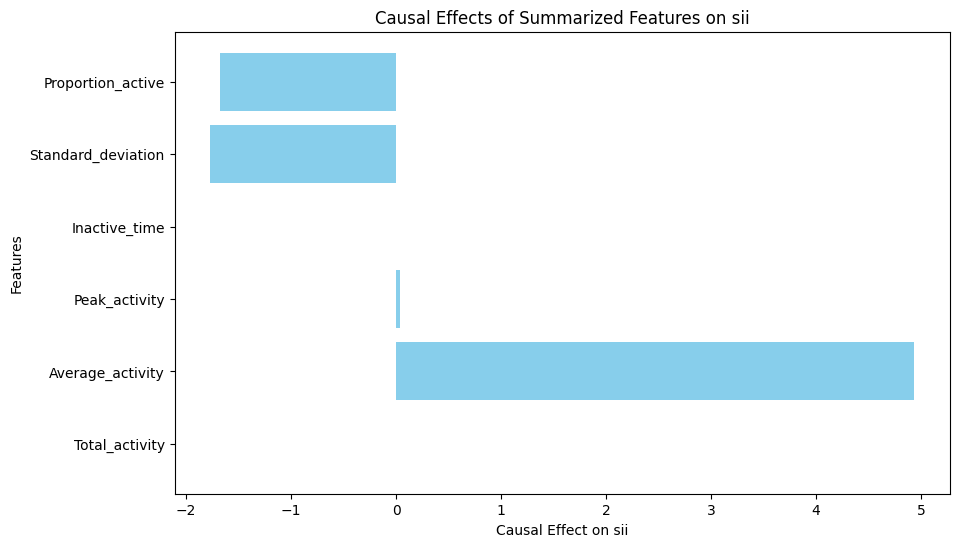

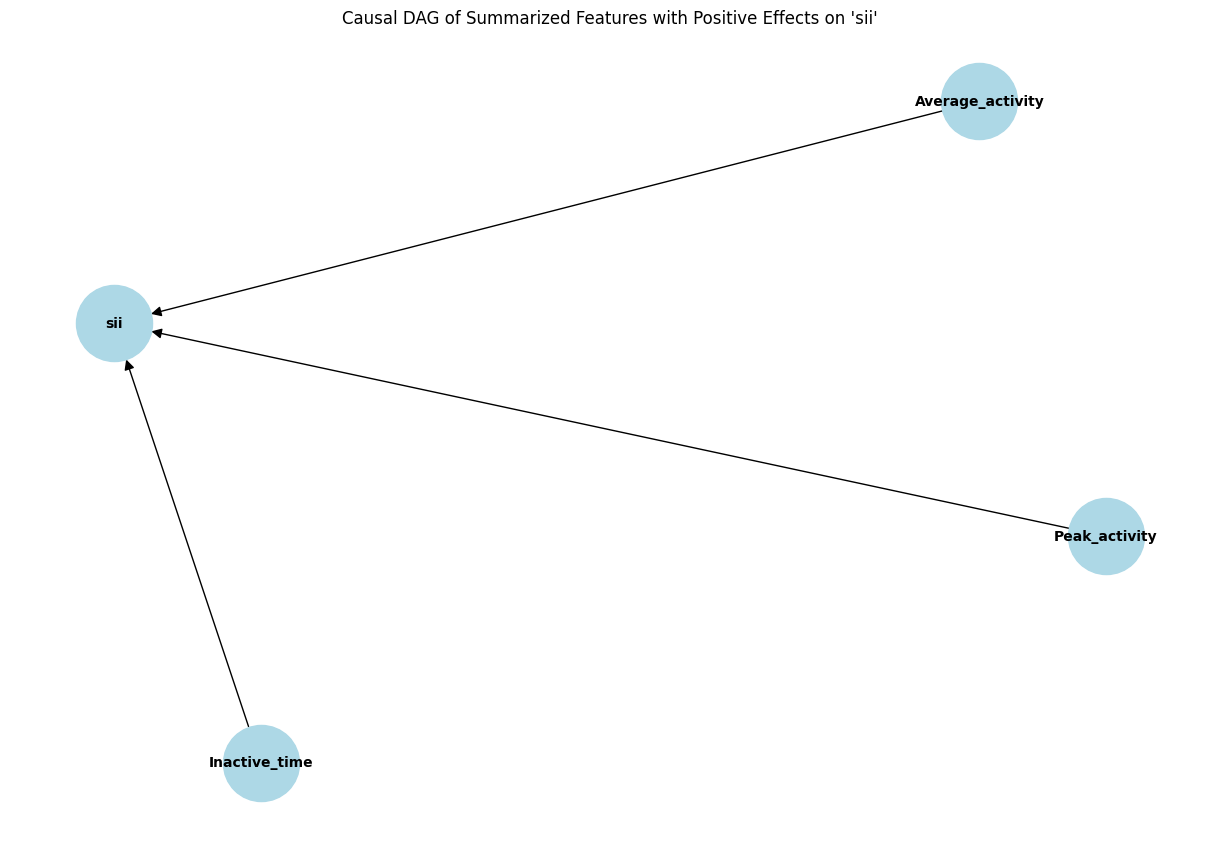

In [83]:
# List of summarized features
summarized_features = [
    'Total_activity', 'Average_activity', 'Peak_activity',
    'Inactive_time', 'Standard_deviation', 'Proportion_active'
]

causal_effects = []

for feature in summarized_features:
    treatment = feature
    confounders = [col for col in summarized_features if col != feature]
    
    causal_model = CausalModel(
        data=summarized_features_df,
        treatment=treatment,
        outcome='sii',
        common_causes=confounders
    )
    
    identified_estimand = causal_model.identify_effect()
    causal_estimate = causal_model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    
    causal_effects.append({
        "Feature": feature,
        "Effect": causal_estimate.value
    })

    print(f"Causal effect of {feature} on sii: {causal_estimate.value}")

causal_effects_df = pd.DataFrame(causal_effects)

plt.figure(figsize=(10, 6))
plt.barh(causal_effects_df['Feature'], causal_effects_df['Effect'], color='skyblue')
plt.xlabel("Causal Effect on sii")
plt.ylabel("Features")
plt.title("Causal Effects of Summarized Features on sii")
plt.show()

# Initialize the DAG
G = nx.DiGraph()

# Add nodes: summarized features and 'sii'
nodes = summarized_features + ['sii']
G.add_nodes_from(nodes)

positive_effect_nodes = []
for index, row in causal_effects_df.iterrows():
    if row['Effect'] > 0:  # Include features with positive causal effects
        G.add_edge(row['Feature'], 'sii')
        positive_effect_nodes.append(row['Feature'])

# Remove nodes that do not have any edges
nodes_to_remove = [node for node in G.nodes if node not in positive_effect_nodes + ['sii']]
G.remove_nodes_from(nodes_to_remove)

# Visualize the DAG
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Define layout for consistent visualization
nx.draw(
    G, pos, with_labels=True, node_size=3000, node_color='lightblue',
    font_size=10, font_weight='bold', arrowsize=15
)
plt.title("Causal DAG of Summarized Features with Positive Effects on 'sii'")
plt.show()



This DAG makes it clear that activity levels do have a significant effect on sii. 

## Analysis of other Time Series Features w.r.t sii

So far, we have performed our analysis on the summarized time features calculated using *enmo*. We can now analyse the remaining time series features in our auxiliary data in a similar way and see if they also have a causal effect on sii.

In [85]:

# Define the columns to extract
columns_to_extract = [
    "anglez", "non-wear_flag", "light", "battery_voltage",
    "time_of_day", "weekday", "quarter", "relative_date_PCIAT", "enmo"
]

# Path to the folder containing parquet files
parquet_folder = "series_train.parquet"  # Update with your actual folder path

# Initialize a list to store the extracted data
extracted_features = []

# Loop through each ID folder in the Parquet folder
for folder in glob.glob(os.path.join(parquet_folder, "id=*")):
    id_ = folder.split('=')[-1]
    parquet_file = glob.glob(os.path.join(folder, "*.parquet"))
    if len(parquet_file) != 1:
        print(f"Skipping folder {folder} due to multiple or no files.")
        continue

    # Load the Parquet file
    df = pd.read_parquet(parquet_file[0], columns=columns_to_extract)

    # Summarize or process the data as required
    INACTIVE_THRESHOLD = 0.1  # Define threshold for inactivity 
    features = {
        'id': id_,
        'anglez_mean': df['anglez'].mean(),
        'non_wear_ratio': df['non-wear_flag'].mean(),
        'light_mean': df['light'].mean(),
        'battery_voltage_mean': df['battery_voltage'].mean(),
        'weekday_mode': df['weekday'].mode()[0] if not df['weekday'].isnull().all() else None,
        'quarter_mode': df['quarter'].mode()[0] if not df['quarter'].isnull().all() else None,
        'relative_date_PCIAT_mean': df['relative_date_PCIAT'].mean(),
        'Total_activity': df['enmo'].sum(),
        'Average_activity': df['enmo'].mean(),
        'Peak_activity': df['enmo'].max(),
        'Inactive_time': (df['enmo'] < INACTIVE_THRESHOLD).sum() * 5,  # Assuming 5-second intervals
        'Standard_deviation': df['enmo'].std(),
        'Proportion_active': (df['enmo'] > INACTIVE_THRESHOLD).mean(),
    }
    extracted_features.append(features)

# Convert to DataFrame
extracted_features_df = pd.DataFrame(extracted_features)

# Display the extracted features
print("Extracted Features:")
print(extracted_features_df.head())


Extracted Features:
         id  anglez_mean  non_wear_ratio  light_mean  battery_voltage_mean  \
0  00115b9f   -10.580416        0.000000   42.296310           4053.579102   
1  001f3379   -55.630768        0.655708   16.771982           3838.189453   
2  00f332d1     6.687338        0.171246   66.563408           3848.583252   
3  01085eb3   -17.589041        0.035210   17.800735           3849.649414   
4  012cadd8    -5.059758        0.000000   54.893394           3974.910645   

   weekday_mode  quarter_mode  relative_date_PCIAT_mean  Total_activity  \
0             5             3                 53.201683     2053.305176   
1             3             3                 79.435593     4727.518555   
2             2             2                 26.152903    12537.293945   
3             2             4                 49.910686    12221.464844   
4             1             4                 -1.168288     5655.915527   

   Average_activity  Peak_activity  Inactive_time  Standard_

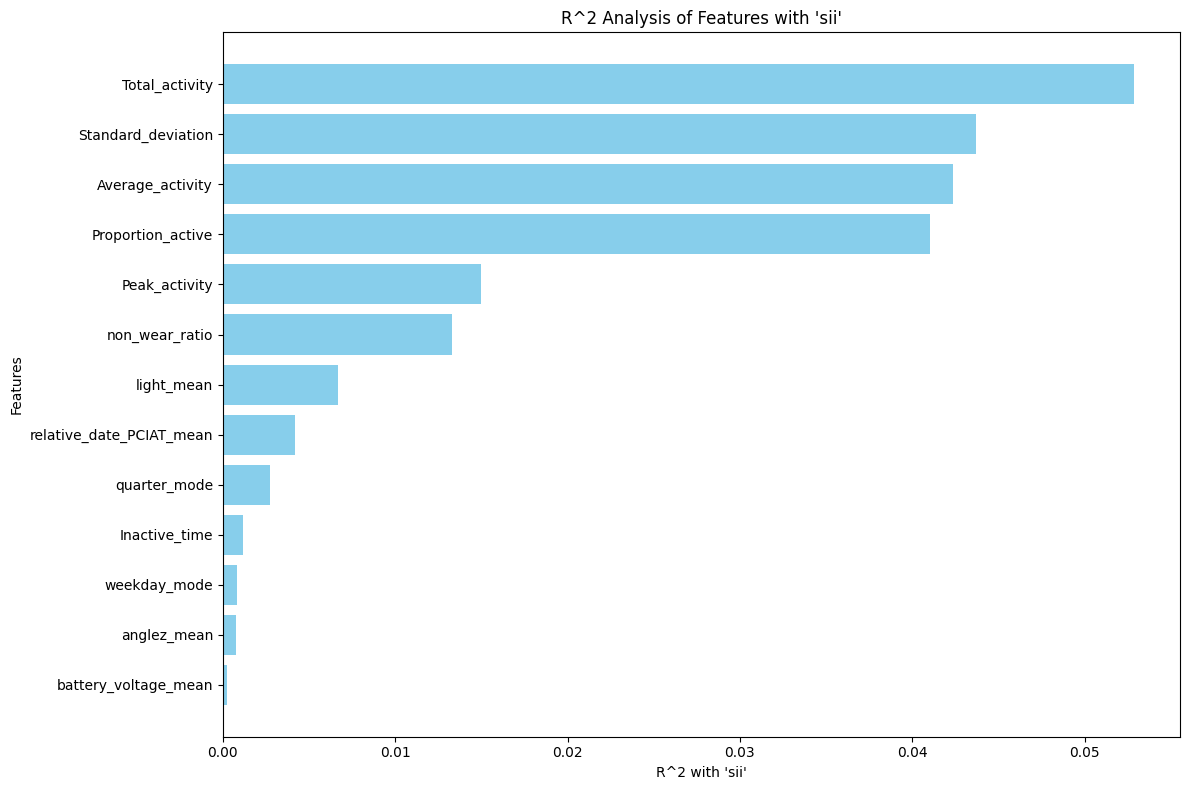

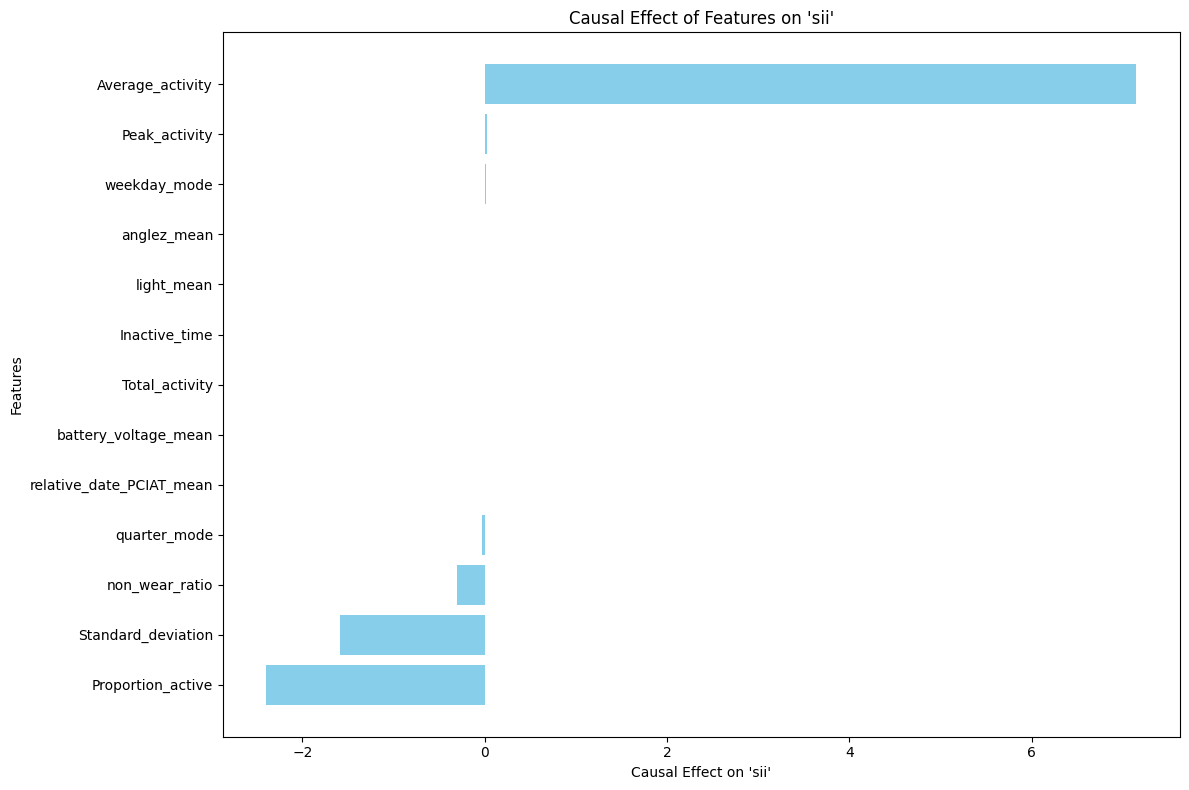

In [86]:
# Merge extracted_features_df with cleaned_data to include 'sii'
if 'id' not in cleaned_data.columns or 'id' not in extracted_features_df.columns:
    raise ValueError("Both extracted_features_df and cleaned_data must have an 'id' column for merging.")

# Merge the dataframes
merged_data = extracted_features_df.merge(cleaned_data[['id', 'sii']], on='id')

# Ensure 'sii' is numeric
if not pd.api.types.is_numeric_dtype(merged_data['sii']):
    print("'sii' is not numeric. Converting to numeric...")
    merged_data['sii'] = pd.Categorical(merged_data['sii']).codes

# List of features to analyze
features = extracted_features_df.columns.difference(['id'])

# Initialize lists for R^2 and causal effects
r2_results = []
causal_effects = []

# Perform R^2 analysis
for feature in features:
    try:
        X = merged_data[[feature]].dropna().values
        y = merged_data['sii'].dropna().values

        if len(X) > 1 and len(y) > 1:
            # Linear regression for R^2
            model = LinearRegression().fit(X, y)
            r2 = r2_score(y, model.predict(X))
            r2_results.append({'Feature': feature, 'R^2': r2})
    except Exception as e:
        print(f"Error with R^2 analysis for {feature}: {e}")

# Convert R^2 results to DataFrame
r2_results_df = pd.DataFrame(r2_results).sort_values(by='R^2', ascending=False)

# Plot R^2 results
plt.figure(figsize=(12, 8))
plt.barh(r2_results_df['Feature'], r2_results_df['R^2'], color='skyblue')
plt.xlabel("R^2 with 'sii'")
plt.ylabel("Features")
plt.title("R^2 Analysis of Features with 'sii'")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Perform causal effect analysis
for feature in features:
    try:
        # Define treatment and confounders
        treatment = feature
        confounders = [col for col in features if col != feature]

        # Create causal model
        causal_model = CausalModel(
            data=merged_data,
            treatment=treatment,
            outcome='sii',
            common_causes=confounders
        )

        # Identify and estimate the effect
        identified_estimand = causal_model.identify_effect()
        causal_estimate = causal_model.estimate_effect(
            identified_estimand,
            method_name="backdoor.linear_regression"
        )

        causal_effects.append({'Feature': feature, 'Causal_Effect': causal_estimate.value})
    except Exception as e:
        print(f"Error with causal effect analysis for {feature}: {e}")

# Convert causal effects to DataFrame
causal_effects_df = pd.DataFrame(causal_effects).sort_values(by='Causal_Effect', ascending=False)

# Plot causal effect results
plt.figure(figsize=(12, 8))
plt.barh(causal_effects_df['Feature'], causal_effects_df['Causal_Effect'], color='skyblue')
plt.xlabel("Causal Effect on 'sii'")
plt.ylabel("Features")
plt.title("Causal Effect of Features on 'sii'")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


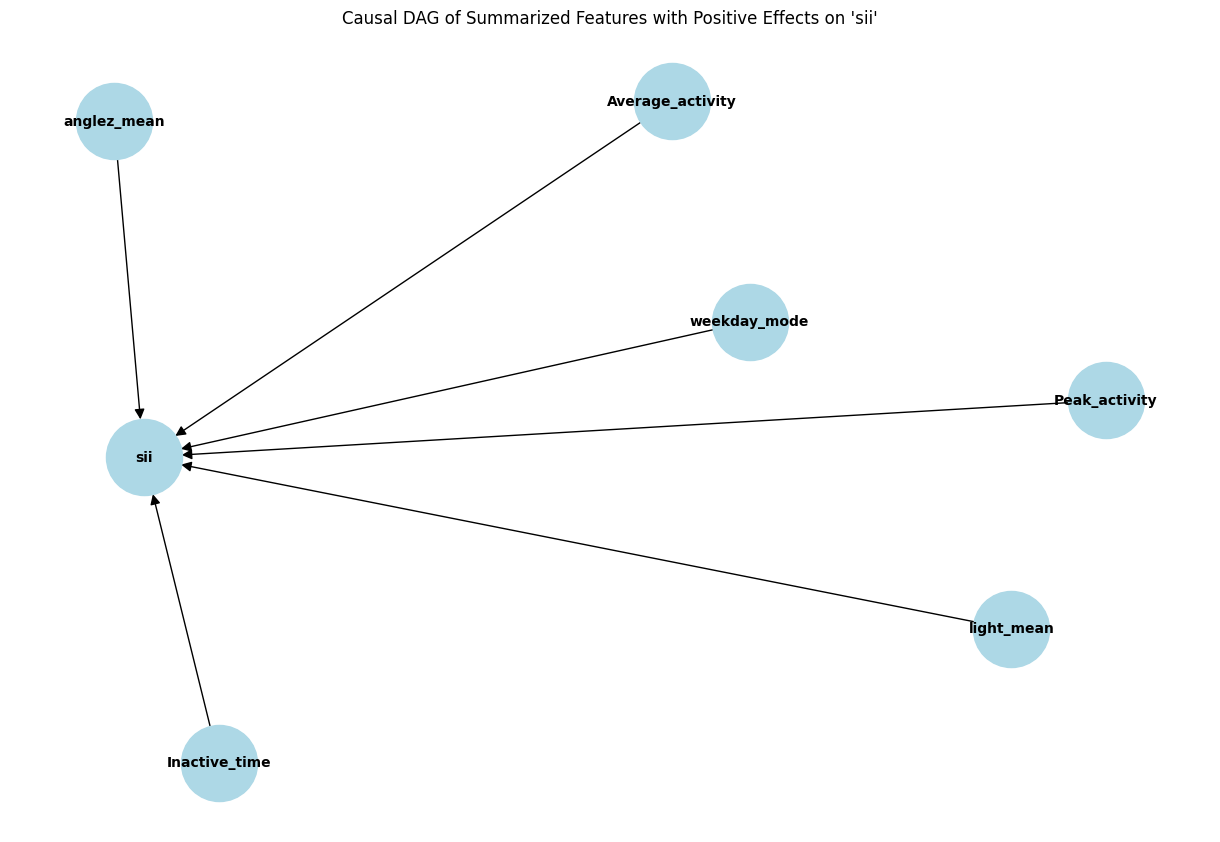

In [ ]:
# Initialize the DAG
G = nx.DiGraph()

# Add nodes: summarized features and 'sii'
nodes = summarized_features + ['sii']
G.add_nodes_from(nodes)

positive_effect_nodes = []
for index, row in causal_effects_df.iterrows():
    if row['Causal_Effect'] > 0:  # Include features with positive causal effects
        G.add_edge(row['Feature'], 'sii')
        positive_effect_nodes.append(row['Feature'])

# Remove nodes that do not have any edges
nodes_to_remove = [node for node in G.nodes if node not in positive_effect_nodes + ['sii']]
G.remove_nodes_from(nodes_to_remove)

# Visualize the DAG
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Define layout for consistent visualization
nx.draw(
    G, pos, with_labels=True, node_size=3000, node_color='lightblue',
    font_size=10, font_weight='bold', arrowsize=15
)
plt.title("Causal DAG of Summarized Features with Positive Effects on 'sii'")
plt.show()


Our final DAG shows us the causal effects of all the parquet file features on the sii together, after filtering out those features that have no edges or no positive causal effect. From our two step process, we can see that not all the features with higher R² values are present in the final graph. These are features that may have had a strong correlation, but no causal relationship. After removing these, we have a model that is suitable for understanding which features influence the sii.
